In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
torch.cuda.empty_cache()

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import transformers
import pytorch_lightning as pl


from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from typing import Sequence
from functools import partial
from collections import Counter

print(torch.__version__)
print(transformers.__version__)
print(torch.cuda.is_available())

1.10.1+cu111
4.27.3
True


## Split Data

In [2]:
# Читаем данные из датасетов
movies_df = pd.read_csv('../input/movies.csv')
ratings_df  = pd.read_csv('../input/ratings.csv')
tags_df  = pd.read_csv('../input/tags.csv')


In [3]:
ratings_df.head() # Смотрю что в них

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [4]:
user_ids = ratings_df["userId"].unique() # Создаю массив с уникальными юзерами
item_ids = ratings_df['movieId'].unique() # Также с фильмами
user_ids, item_ids, ratings_df["userId"].nunique(), ratings_df['movieId'].nunique()

(array([     1,      2,      3, ..., 283226, 283227, 283228], dtype=int64),
 array([   307,    481,   1091, ..., 117857, 133409, 142855], dtype=int64),
 283228,
 53889)

In [5]:
#uid2idx = {uid: idx for idx, uid in enumerate(user_ids)}
#iid2idx = {iid: idx for idx, iid in enumerate(item_ids)}
#idx2uid = {idx: uid for uid, idx in uid2idx.items()}
#idx2iid = {idx: iid for iid, idx in iid2idx.items()}
#ratings_df['userId'] = ratings_df['userId'].map(uid2idx)
#ratings_df['movieId'] = ratings_df['movieId'].map(iid2idx)
#ratings_df
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42) # сплитим данные

In [6]:
train_data

,userId,movieId,rating,timestamp
16835200,172143,3740,2.0,992045228
247145,2440,1185,3.5,1356461438
3713038,38145,3275,0.5,1471179958
8088192,83252,223,5.0,1008482300
15588145,159137,4389,3.5,1065371794
...,...,...,...,...
21081788,215366,115122,4.5,1507121815
26858567,274263,4262,4.0,1400987773
23327850,238530,590,3.0,834347371
16094478,164462,4643,3.5,1238069592


In [7]:
print('Number of users: ', len(user_ids))
print('Number of movies: ', len(item_ids))
print('Number of interactions: ', len(ratings_df))
print('Average rating: ', ratings_df['rating'].mean())
print('Start Date: ', pd.to_datetime(ratings_df['timestamp'].min(), unit='s'))
print('End Date: ', pd.to_datetime(ratings_df['timestamp'].max(), unit='s'))

Number of users:  283228
Number of movies:  53889
Number of interactions:  27753444
Average rating:  3.5304452124932677
Start Date:  1995-01-09 11:46:44
End Date:  2018-09-26 06:59:09


In [8]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [9]:
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42) # val train 20/80 эмпирически выверенное отношение))))

## Creating NN

In [10]:
from pytorch_lightning.utilities.types import EVAL_DATALOADERS


class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    loss_val = []
    val_losses = []
    loss_train = []
    train_losses = []
    
    def __init__(self, num_users, num_items, ratings_train, ratings_val, all_movieIds):
        super().__init__()

        # Определяем слои для входных эмбеддингов пользователей и фильмов
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)

        # Определяем полносвязные слои и выходной слой сигмоидной активации
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)

        # Сохраняем оценки фильмов и список всех фильмов
        self.ratings_train = ratings_train
        self.ratings_val = ratings_val
        self.all_movieIds = all_movieIds
        
        
    def forward(self, user_input, item_input):
        
        # Передаем входные данные через слои эмбеддингов
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Объединяем эмбеддинги
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Проходим через полносвязные слои
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Выходной слой
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        # Бинарная перекрестная энтропия как функция потери
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        self.loss_train.append(loss.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        self.loss_val.append(loss.item())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings_train, self.all_movieIds),
                          batch_size=512)
    
    def val_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings_val, self.all_movieIds),
                          batch_size=512) # можно добавить num_workers - у меня работало в колабе, но на своем устройстве ошибка c PID 
                                          # https://stackoverflow.com/questions/60101168/pytorch-runtimeerror-dataloader-worker-pids-15332-exited-unexpectedly
    
    def on_train_epoch_end(self):
        avg_loss = np.average(self.loss_train)
        self.loss_train.clear()
        self.train_losses.append(avg_loss)

    def on_validation_epoch_end(self):
        avg_loss = np.average(self.loss_val)
        self.loss_val.clear()
        self.val_losses.append(avg_loss)  

In [11]:
num_users = ratings_df['userId'].max()+1
num_items = ratings_df['movieId'].max()+1

all_movieIds = ratings_df['movieId'].unique()


In [12]:
#TODO cross-validation
model = NCF(num_users, num_items, train_data, valid_data, all_movieIds)
trainer = pl.Trainer(max_epochs=3, accelerator="gpu", devices=1, reload_dataloaders_every_n_epochs=0,
                     enable_progress_bar=True, logger=False, enable_checkpointing=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.3 M 
1 | item_embedding | Embedding | 1.6 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.281    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\StepW\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\StepW\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [14]:
torch.save({
    'model_state_dict': model.state_dict(),
}, 'with_val_3_epoches.pth')

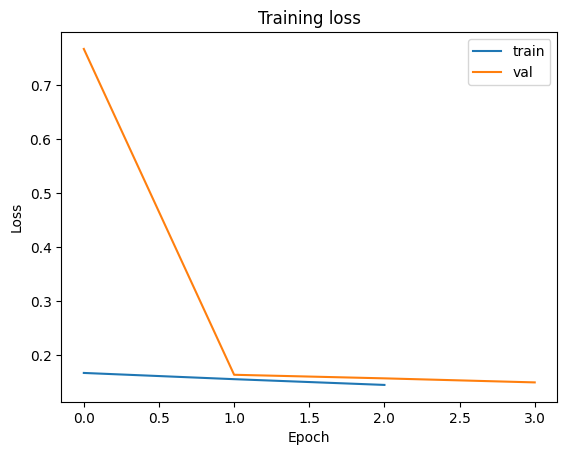

In [15]:
#plt.subplot(1, 2, 1)
plt.plot(model.train_losses)
plt.plot(model.val_losses)
plt.legend(['train','val'])
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
ratings_df_copy = ratings_df.copy()
test_data_copy = test_data.copy()

# Перемешаю и дропну некоторые тестовые данные для экономии времени (можно сделать на всех если есть время)
test_data_copy.sample(frac=1)
test_data_copy.drop(test_data_copy.index[int(len(test_data_copy)/100):len(test_data_copy)-1], axis=0, inplace=True) 

# Создаем множество пользователей и фильмов из тестовых данных
test_user_item_set = set(zip(test_data_copy['userId'], test_data_copy['movieId']))

# Группируем идентификаторы фильмов для каждого пользователя в словаре
user_interacted_items = ratings_df_copy.groupby('userId')['movieId'].apply(list).to_dict()

# Создаем список для хранения результатов оценки качества предсказаний
hits = []

# Для каждой пары (пользователь, фильм) в тестовых данных
for (u,i) in tqdm(test_user_item_set):

    # Получаем список идентификаторов фильмов, с которыми взаимодействовал данный пользователь
    interacted_items = user_interacted_items[u]

    # Создаем множество идентификаторов фильмов, с которыми пользователь не взаимодействовал
    not_interacted_items = set(all_movieIds) - set(interacted_items)

    # Случайным образом выбираем 99 не взаимодействовавших фильмов и добавляем целевой фильм
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    # Получаем предсказанные оценки для каждого из выбранных фильмов
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    # Получаем идентификаторы 10 фильмов с наивысшими предсказанными оценками
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    # Проверяем, содержится ли целевой фильм в топ-10 предсказанных
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
# Выводим значение метрики Hit Ratio @ 10        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

100%|██████████| 55507/55507 [10:34<00:00, 87.43it/s] 

The Hit Ratio @ 10 is 0.95
